In [1]:
import sys, os

from ase.db import connect

import torch
import torchmetrics
import pytorch_lightning as pl
import schnetpack as spk

import spainn
import spainn.properties as sp

In [2]:
model_dir = '/git/cyanines/train'
model_file = os.path.join(model_dir, 'best_model_E_F_C')
split_file = os.path.join(model_dir, 'split.npz')

In [3]:
datapath = '/nc/Cyanine/all_via_module_interface.db'
db = connect(datapath)

db.get(1).data.keys()

dict_keys(['energy', 'forces', 'dipoles', 'nacs', 'smooth_nacs'])

In [4]:
db.metadata |= {
    'atomrefs': {}
}

db.metadata

{'ReferenceMethod': 'Unknown',
 '_distance_unit': 'Bohr',
 '_property_unit_dict': {'energy': 'Hartree',
  'forces': 'Hartree/Bohr',
  'nacs': '1',
  'dipoles': '1',
  'smooth_nacs': '1'},
 'n_singlets': 3,
 'n_duplets': 0,
 'n_triplets': 0,
 'atomrefs': {}}

In [5]:
try:
    os.rename(split_file, split_file + '.old')
except FileNotFoundError: pass

data_module = sp.SPAINN(
    n_states = 3, # singlet states 0, 1, 2
    n_nacs = 3, # couplings: 01, 02, 12
    datapath=datapath, # path to database
    batch_size=2,
    num_train=0.7, # 70% of databse for training
    num_val=0.1, # 10% of database for validation
    split_file=split_file,
    splitting=spk.data.splitting.RandomSplit(),
    load_properties=['energy', 'forces', 'smooth_nacs'],
    transforms=[
        # remove mean of energy in every electronic state
        spk.transform.RemoveOffsets(sp.SPAINN.energy, remove_mean=True, remove_atomrefs=False),
        spk.transform.ASENeighborList(cutoff=5.0),
        spk.transform.CastTo32(),
            ],
)

# setup everything
data_module.prepare_data()
data_module.setup()

100%|████████████████████████████████████████| 389/389 [00:01<00:00, 295.05it/s]

{'energy': (tensor([-15.9332, -15.9277, -15.9236], dtype=torch.float64), tensor([0.0016, 0.0013, 0.0013], dtype=torch.float64))}


In [6]:
props = data_module.dataset[0]
print(*[f'{k:>20}\t{props[k].shape}' for k in props], sep='\n')

                _idx	torch.Size([1])
              energy	torch.Size([1, 3])
              forces	torch.Size([24, 3, 3])
         smooth_nacs	torch.Size([24, 3, 3])
            _n_atoms	torch.Size([1])
     _atomic_numbers	torch.Size([24])
          _positions	torch.Size([24, 3])
               _cell	torch.Size([1, 3, 3])
                _pbc	torch.Size([3])


In [7]:
n_atom_basis = 50
cutoff = 10.0

# input module: calculates pairwise distances between atoms
pairwise_distance = spk.atomistic.PairwiseDistances()

# radial basis for convolution
radial_basis = spk.nn.GaussianRBF(n_rbf=20, cutoff=cutoff)

In [8]:
# PaiNN Representation
painn = spk.representation.PaiNN(
    radial_basis = radial_basis,
    n_atom_basis=n_atom_basis,
    n_interactions=6,
    cutoff_fn=spk.nn.CosineCutoff(cutoff)
)

In [9]:
pred_energy = spainn.model.Atomwise(
    n_in=n_atom_basis,
    n_out=3, # number of electronic states (S0, S1, S2)
    n_layers=3,
)

pred_forces = spainn.model.Forces()

pred_nacs = spainn.model.Nacs(
    n_in=n_atom_basis,
    n_out=3, # number of couplings (C01, C02, C12)
    nac_key=sp.SPAINN.smooth_nacs,
    use_vector_repr=True # False for SchNet
)

In [10]:
nnpot = spk.model.NeuralNetworkPotential(
    representation=painn,
    input_modules=[pairwise_distance],
    output_modules=[pred_energy, pred_forces, pred_nacs],
    input_dtype_str='float32',
    do_postprocessing=True,
    postprocessors=[
        spk.transform.CastTo64(),
        spk.transform.AddOffsets(spainn.SPAINN.energy, add_mean=True, add_atomrefs=False),
    ],
)

In [11]:
output_energy = spk.task.ModelOutput(
    name=spainn.SPAINN.energy,
    loss_fn=torch.nn.MSELoss(),
    loss_weight=1.0, #0.05,
    metrics={
        "MSE": torchmetrics.MeanSquaredError(),
    },
)

output_forces = spk.task.ModelOutput(
    name=spainn.SPAINN.forces,
    loss_fn=torch.nn.MSELoss(),
    loss_weight=1.0, #0.10,
    metrics={
        "MSE": torchmetrics.MeanSquaredError(),
    },
)

output_nacs = spk.task.ModelOutput(
    name=sp.SPAINN.smooth_nacs,
    # MSE loss function for phase properties
    loss_fn=spainn.loss.PhaseLossAtomisticMSE(atoms=6),
    loss_weight=1.0, #0.85,
    metrics={
        "MSE": spainn.metric.PhaseAtomisticMSE(atoms=6),
    },
)


In [12]:
import warnings; warnings.simplefilter('ignore')

task = spk.task.AtomisticTask(
    model=nnpot,
    outputs=[output_energy, output_forces, output_nacs],
    optimizer_cls=torch.optim.AdamW,
    optimizer_args={"lr": 1e-4},
    scheduler_monitor="val_loss",
)


callbacks = [
    spk.train.ModelCheckpoint(
        model_path=model_file,
        save_top_k=1,
        monitor="val_loss"
    )
]

trainer = pl.Trainer(
    log_every_n_steps=1,
    callbacks=callbacks,
    logger=pl.loggers.TensorBoardLogger(save_dir=model_dir),
    default_root_dir=model_dir,
    max_epochs=100, # for testing, we restrict the number of epochs
)

trainer.fit(task, datamodule=data_module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX 2000 Ada Generation Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                   | Params
---------------------------------------------------
0 | model   | NeuralNetworkPotential | 202 K 
1 | outputs | ModuleList             | 0     
---------------------------------------------------
202 K     Trainable params
0         Non-trainable params
202 K     Total params
0.811     Total estimated model params size (MB)


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


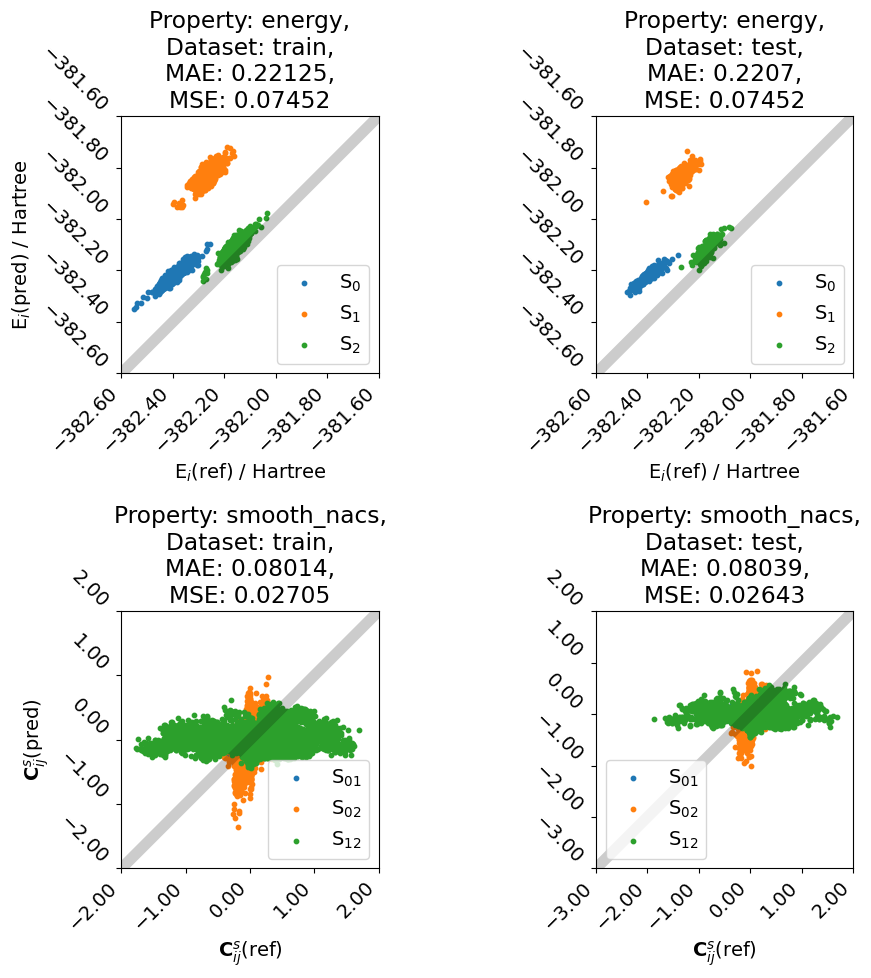

In [15]:
import spainn.plotting as sp

plotter = sp.PlotMAE(
  database = datapath,
  split_file = split_file,
  model_file = model_file,
  cutoff = cutoff,
  properties2plot=['energy', 'smooth_nacs'],
  subset2plot=['train', 'test'],
)

plotter.plot()